# EMCal clustering with Tensorflow/Keras

## 1. Preprocess data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

In [2]:
N = 20000

file = uproot.open('data/merged_20000_evts.root')
tree = file['ttree']


pid = tree['truthpar_id'].array(library='np', entry_stop=N)
px = tree['truthpar_px'].array(library='np', entry_stop=N)
py = tree['truthpar_py'].array(library='np', entry_stop=N)
pz = tree['truthpar_pz'].array(library='np', entry_stop=N)

pid = np.concatenate(pid,axis=0)
pid = (pid == 22).astype(int)

px = np.concatenate(px,axis=0)
py = np.concatenate(py,axis=0)
pz = np.concatenate(pz,axis=0)

In [3]:
pt = []
eta = []
phi = []

for i in range(N):
    pt.append(np.sqrt(px[i]*px[i]+py[i]*py[i]+pz[i]*pz[i]))
    p = np.sqrt(px[i]*px[i]+py[i]*py[i]+pz[i]*pz[i])
    eta.append(0.5 * np.log((p + pz[i]) / (p - pz[i])))
    phi.append(np.arctan2(py[i],px[i]))
    
pt = np.array(pt)
eta = np.array(eta)
phi = np.array(phi)

In [4]:
e_tow = tree['emcalen'].array(library='np', entry_stop=N)
eta_tow = tree['emcalet'].array(library='np', entry_stop=N)
phi_tow = tree['emcalph'].array(library='np', entry_stop=N)

In [5]:
eta_values = set()

for et in eta_tow:
    eta_values = eta_values.union(set(et))
    
eta_values = list(eta_values)
eta_values.sort()

eta_dict = dict()

for i,et in enumerate(eta_values):
    eta_dict[et] = i

In [6]:
phi_values = set()

for ph in phi_tow:
    phi_values = phi_values.union(set(ph))
    
phi_values = list(phi_values)
phi_values.sort()

phi_dict = dict()

for i,ph in enumerate(phi_values):
    phi_dict[ph] = i

In [7]:
ieta_tow = []
iphi_tow = [] 

for et,ph in zip(eta_tow,phi_tow):
    ieta_event = []
    iphi_event = []
    for e,p in zip(et,ph):
        ieta_event.append(eta_dict[e])
        iphi_event.append(phi_dict[p])
    ieta_tow.append(np.array(ieta_event))
    iphi_tow.append(np.array(iphi_event))
    
ieta_tow = np.array(ieta_tow,dtype=object)
iphi_tow = np.array(iphi_tow,dtype=object)

In [8]:
seed_e = np.zeros(N)
seed_eta = np.zeros(N)
seed_ieta = np.zeros(N,dtype=int)
seed_phi = np.zeros(N)
seed_iphi = np.zeros(N,dtype=int)

nmax_e = np.zeros(N)
nmax_eta = np.zeros(N)
nmax_ieta = np.zeros(N,dtype=int)
nmax_phi = np.zeros(N)
nmax_iphi = np.zeros(N,dtype=int)

i = 0
for e,et,ph in zip(e_tow,eta_tow,phi_tow):
    e_copy = e.copy()
    e_copy.sort()
    seed_e[i] = e_copy[-1]
    seed_index = list(e).index(seed_e[i])
    seed_eta[i] = et[seed_index]
    seed_ieta[i] = eta_dict[seed_eta[i]]
    seed_phi[i] = ph[seed_index]
    seed_iphi[i] = phi_dict[seed_phi[i]]
    
    nmax_e[i] = e_copy[-2]
    nmax_index = list(e).index(nmax_e[i])
    nmax_eta[i] = et[nmax_index]
    nmax_ieta[i] = eta_dict[nmax_eta[i]]
    nmax_phi[i] = ph[nmax_index]
    nmax_iphi[i] = phi_dict[nmax_phi[i]]
    
    i += 1

In [9]:
clusters = np.zeros((N,25),dtype=float)
clusters7x7 = np.zeros((N,49),dtype=float)
clusters9x9 = np.zeros((N,81),dtype=float)
clusters19x19 = np.zeros((N,19*19),dtype=float)

clusters_2d = np.zeros((N,5,5),dtype=float)
clusters9x9_2d = np.zeros((N,9,9),dtype=float)
clusters19x19_2d = np.zeros((N,19,19),dtype=float)

for i in range(N):
    if seed_e[i] < 0.1 or seed_ieta[i] < 2 or seed_ieta[i] > 93:
        continue
    
    for iet in range(0,5):
        for iph in range(0,5):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-2) & (iphi_tow[i] == (iph+seed_iphi[i]-2) % 256))[0]
            if len(index) == 1:
                clusters[i][iet + iph*5] = e_tow[i][index]/seed_e[i]
                clusters_2d[i][iet][iph] = e_tow[i][index]/seed_e[i]
            else:
                clusters[i][iet + iph*5] = 0
                clusters_2d[i][iet][iph] = 0
     
    for iet in range(0,7):
        for iph in range(0,7):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-3) & (iphi_tow[i] == (iph+seed_iphi[i]-3) % 256))[0]
            if len(index) == 1:
                clusters7x7[i][iet + iph*7] = e_tow[i][index]/seed_e[i]
            else:
                clusters7x7[i][iet + iph*7] = 0
                
    for iet in range(0,9):
        for iph in range(0,9):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-4) & (iphi_tow[i] == (iph+seed_iphi[i]-4) % 256))[0]
            if len(index) == 1:
                clusters9x9[i][iet + iph*9] = e_tow[i][index]/seed_e[i]
                clusters9x9_2d[i][iet][iph] = e_tow[i][index]/seed_e[i]
            else:
                clusters9x9[i][iet + iph*9] = 0
                clusters9x9_2d[i][iet][iph] = 0
                
    for iet in range(0,19):
        for iph in range(0,19):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-9) & (iphi_tow[i] == (iph+seed_iphi[i]-9) % 256))[0]
            if len(index) == 1:
                clusters19x19[i][iet + iph*19] = e_tow[i][index]/seed_e[i]
                clusters19x19_2d[i][iet][iph] = e_tow[i][index]/seed_e[i]
            else:
                clusters19x19[i][iet + iph*19] = 0
                clusters19x19_2d[i][iet][iph] = 0

In [34]:
condition = (seed_e > 0.1) & (seed_ieta > 8) & (seed_ieta < 88)
pidNN_cleaned = pid[np.where(condition)[0]]
clusters5x5_cleaned = clusters[np.where(condition)[0]]
clusters7x7_cleaned = clusters7x7[np.where(condition)[0]]
clusters9x9_cleaned = clusters9x9[np.where(condition)[0]]
clusters19x19_cleaned = clusters19x19[np.where(condition)[0]]

clusters5x5_2d_cleaned = clusters_2d[np.where(condition)[0]]
clusters9x9_2d_cleaned = clusters9x9_2d[np.where(condition)[0]]
clusters19x19_2d_cleaned = clusters19x19_2d[np.where(condition)[0]]

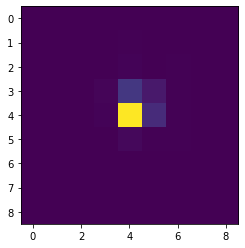

In [11]:
plt.imshow(clusters9x9_2d_cleaned[0])

## 2. Build Keras model

In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models

2022-09-30 20:59:39.916568: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
model = models.Sequential(
    [
        keras.Input(shape=(9*9,)),
        layers.Dense(16,activation="relu"),
        layers.Dense(16,activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ]

)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## 3. Test Keras model

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clusters9x9_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

Epoch 1/50
296/296 [==============================] - 1s 2ms/step - loss: 0.6349 - accuracy: 0.6780 - val_loss: 0.5626 - val_accuracy: 0.7265
Epoch 2/50
296/296 [==============================] - 0s 1ms/step - loss: 0.5085 - accuracy: 0.7691 - val_loss: 0.4792 - val_accuracy: 0.7835
Epoch 3/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4594 - accuracy: 0.8022 - val_loss: 0.4397 - val_accuracy: 0.8091
Epoch 4/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.8216 - val_loss: 0.4143 - val_accuracy: 0.8253
Epoch 5/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4126 - accuracy: 0.8302 - val_loss: 0.3959 - val_accuracy: 0.8262
Epoch 6/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3951 - accuracy: 0.8377 - val_loss: 0.3821 - val_accuracy: 0.8367
Epoch 7/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3791 - accuracy: 0.8456 - val_loss: 0.3636 - val_accuracy: 0.8528
Epoch 

In [16]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 835us/step - loss: 0.2739 - accuracy: 0.9080


[0.27388614416122437, 0.9079861044883728]

In [17]:
from sklearn import metrics

fpr_dnn, tpr_dnn, thresholds = metrics.roc_curve(y_test, model.predict(X_test))

162/162 [==============================] - 0s 605us/step


## 4. Convolutional neural network models

In [18]:
model2 = keras.Sequential(
    [
        keras.Input(shape=(19,19,1)),
        layers.Conv2D(30, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(15, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(clusters19x19_2d_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

model2.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

Epoch 1/50
296/296 [==============================] - 3s 11ms/step - loss: 0.5634 - accuracy: 0.7157 - val_loss: 0.4614 - val_accuracy: 0.7987
Epoch 2/50
296/296 [==============================] - 3s 9ms/step - loss: 0.4337 - accuracy: 0.8188 - val_loss: 0.3757 - val_accuracy: 0.8414
Epoch 3/50
296/296 [==============================] - 3s 9ms/step - loss: 0.3755 - accuracy: 0.8553 - val_loss: 0.3257 - val_accuracy: 0.8727
Epoch 4/50
296/296 [==============================] - 3s 9ms/step - loss: 0.3385 - accuracy: 0.8786 - val_loss: 0.3198 - val_accuracy: 0.8946
Epoch 5/50
296/296 [==============================] - 3s 9ms/step - loss: 0.3269 - accuracy: 0.8785 - val_loss: 0.2850 - val_accuracy: 0.9012
Epoch 6/50
296/296 [==============================] - 3s 9ms/step - loss: 0.3148 - accuracy: 0.8882 - val_loss: 0.2827 - val_accuracy: 0.9069
Epoch 7/50
296/296 [==============================] - 3s 10ms/step - loss: 0.2989 - accuracy: 0.8947 - val_loss: 0.2798 - val_accuracy: 0.8993
Epoc

In [20]:
model2.evaluate(X_test, y_test)

162/162 [==============================] - 1s 3ms/step - loss: 0.2513 - accuracy: 0.9313


[0.25132471323013306, 0.9313271641731262]

In [21]:
fpr_cnn, tpr_cnn, thresholds = metrics.roc_curve(y_test, model2.predict(X_test))

162/162 [==============================] - 0s 2ms/step


DNN:
pi0 rejection rate at 90% photon efficiency: 0.8928847641144625
photon rejection rate at 90% pi0 efficiency: 0.8826020015396459

CNN:
pi0 rejection rate at 90% photon efficiency: 0.9265274555297757
photon rejection rate at 90% pi0 efficiency: 0.9615088529638183


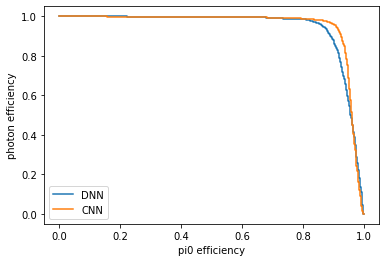

In [22]:
plt.plot(1-fpr_dnn,tpr_dnn,label="DNN")
plt.plot(1-fpr_cnn,tpr_cnn,label="CNN")
plt.xlabel("pi0 efficiency")
plt.ylabel("photon efficiency")
plt.legend();

print("DNN:")
print("pi0 rejection rate at 90% photon efficiency:",np.interp(0.9,tpr_dnn,1-fpr_dnn))
print("photon rejection rate at 90% pi0 efficiency:",np.interp(0.1,fpr_dnn,tpr_dnn))
print("")
print("CNN:")
print("pi0 rejection rate at 90% photon efficiency:",np.interp(0.9,tpr_cnn,1-fpr_cnn))
print("photon rejection rate at 90% pi0 efficiency:",np.interp(0.1,fpr_cnn,tpr_cnn))

## 5. Classification using 5 x 5 

In [24]:
model3 = models.Sequential(
    [
        layers.Input(shape=(5*5)),
        layers.Dense(16,activation="relu"),
        layers.Dense(16,activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ]

)

model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
model4 = models.Sequential(
    [
        layers.Input(shape=(5,5,1)),
        layers.Conv2D(30, kernel_size=(2, 2), activation="relu"),
        layers.Conv2D(15, kernel_size=(2, 2), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(clusters5x5_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

model3.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

model3.evaluate(X_test, y_test)
fpr_dnn_5x5, tpr_dnn_5x5, thresholds = metrics.roc_curve(y_test, model3.predict(X_test))

Epoch 1/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3261 - accuracy: 0.8727 - val_loss: 0.3253 - val_accuracy: 0.8746
Epoch 2/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3233 - accuracy: 0.8755 - val_loss: 0.3286 - val_accuracy: 0.8775
Epoch 3/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3260 - accuracy: 0.8718 - val_loss: 0.3244 - val_accuracy: 0.8737
Epoch 4/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3240 - accuracy: 0.8741 - val_loss: 0.3275 - val_accuracy: 0.8765
Epoch 5/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3232 - accuracy: 0.8730 - val_loss: 0.3222 - val_accuracy: 0.8756
Epoch 6/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3229 - accuracy: 0.8742 - val_loss: 0.3252 - val_accuracy: 0.8756
Epoch 7/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3223 - accuracy: 0.8765 - val_loss: 0.3267 - val_accuracy: 0.8689
Epoch 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(clusters5x5_2d_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

model4.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

model4.evaluate(X_test, y_test)
fpr_cnn_5x5, tpr_cnn_5x5, thresholds = metrics.roc_curve(y_test, model4.predict(X_test))

Epoch 1/50
296/296 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.7964 - val_loss: 0.4228 - val_accuracy: 0.8167
Epoch 2/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4339 - accuracy: 0.7981 - val_loss: 0.4240 - val_accuracy: 0.8110
Epoch 3/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4418 - accuracy: 0.7917 - val_loss: 0.4461 - val_accuracy: 0.7996
Epoch 4/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4384 - accuracy: 0.7944 - val_loss: 0.4234 - val_accuracy: 0.8139
Epoch 5/50
296/296 [==============================] - 1s 2ms/step - loss: 0.4324 - accuracy: 0.7999 - val_loss: 0.4233 - val_accuracy: 0.8205
Epoch 6/50
296/296 [==============================] - 1s 2ms/step - loss: 0.4399 - accuracy: 0.7962 - val_loss: 0.4306 - val_accuracy: 0.8120
Epoch 7/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4376 - accuracy: 0.7952 - val_loss: 0.4497 - val_accuracy: 0.8034
Epoch 

dnn_5x5:
pi0 rejection rate at 90% photon efficiency: 0.820185614849188
photon rejection rate at 90% pi0 efficiency: 0.5954580446497305

cnn_5x5:
pi0 rejection rate at 90% photon efficiency: 0.6918020108275329
photon rejection rate at 90% pi0 efficiency: 0.44380292532717475


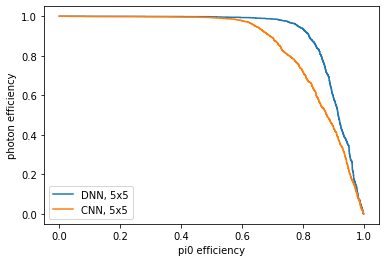

In [43]:
plt.plot(1-fpr_dnn_5x5,tpr_dnn_5x5,label="DNN, 5x5")
plt.plot(1-fpr_cnn_5x5,tpr_cnn_5x5,label="CNN, 5x5")
plt.xlabel("pi0 efficiency")
plt.ylabel("photon efficiency")
plt.legend();

print("dnn_5x5:")
print("pi0 rejection rate at 90% photon efficiency:",np.interp(0.9,tpr_dnn_5x5,1-fpr_dnn_5x5))
print("photon rejection rate at 90% pi0 efficiency:",np.interp(0.1,fpr_dnn_5x5,tpr_dnn_5x5))
print("")
print("cnn_5x5:")
print("pi0 rejection rate at 90% photon efficiency:",np.interp(0.9,tpr_cnn_5x5,1-fpr_cnn_5x5))
print("photon rejection rate at 90% pi0 efficiency:",np.interp(0.1,fpr_cnn_5x5,tpr_cnn_5x5))